# Hybrid Quantum-Classical Image Classifier

This notebook implements a hybrid approach combining:
- **Classical CNN**: For feature extraction from images
- **Quantum Kernel**: For classification using quantum computing

The workflow consists of:
1. Data loading and preprocessing
2. CNN training for feature extraction
3. Feature extraction from images
4. Quantum kernel training and SVM classification
5. Model evaluation

## Configuration

Set the training parameters and choose whether to retrain models:

In [7]:
# Training configuration
RETRAIN_CNN = False  # Set to True to retrain CNN from scratch
RETRAIN_QUANTUM = False  # Set to True to retrain quantum kernel from scratch

# Hyperparameters
BATCH_SIZE = 100
LEARNING_RATE = 0.0001
CNN_EPOCHS = 5
IMG_SIZE = 224
QUANTUM_ITERATIONS = 700
QUANTUM_LEARNING_RATE = 0.2

# Quantum circuit parameters
NUM_WIRES = 5
NUM_LAYERS = 3

# Data sampling (for computational efficiency)
TRAIN_SAMPLES_FOR_QUANTUM = 400  # Number of training samples to use for quantum kernel
VAL_SAMPLES_FOR_QUANTUM = 1000  # Number of validation samples to use
TEST_SAMPLES = 100  # Number of test samples to evaluate

print("Configuration set successfully!")
print(f"Retrain CNN: {RETRAIN_CNN}")
print(f"Retrain Quantum Kernel: {RETRAIN_QUANTUM}")

Configuration set successfully!
Retrain CNN: False
Retrain Quantum Kernel: False


## 1. Import Required Libraries

In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Add src to path for imports
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom modules
from data.data_loading import prepare_data_loaders
from models.cnn_model import CnnFeatureExtractor
from models.quantum_kernel import create_quantum_kernel
from utils.training import train_cnn, train_quantum_kernel, predict_with_quantum_kernel

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: False


## 2. Setup Device and Random Seed

In [9]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(333)
if device == "cuda":
    torch.cuda.manual_seed_all(333)
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 3. Load and Prepare Data

Loading the Dogs vs Cats dataset and creating data loaders for training, validation, and testing.

In [10]:
# Prepare data
data_dir = os.path.join("..", "data", "DogsAndCats")

print("Loading data...")
train_loader, val_loader, test_loader = prepare_data_loaders(
    data_dir, BATCH_SIZE, IMG_SIZE
)

print(f"\nData loaded successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Total training samples: {len(train_loader.dataset)}")
print(f"Total validation samples: {len(val_loader.dataset)}")
print(f"Total test samples: {len(test_loader.dataset)}")

Loading data...

Data loaded successfully!
Training batches: 175
Validation batches: 75
Test batches: 125
Total training samples: 17500
Total validation samples: 7500
Total test samples: 12500


### Visualize Sample Images

Sample images from training set:


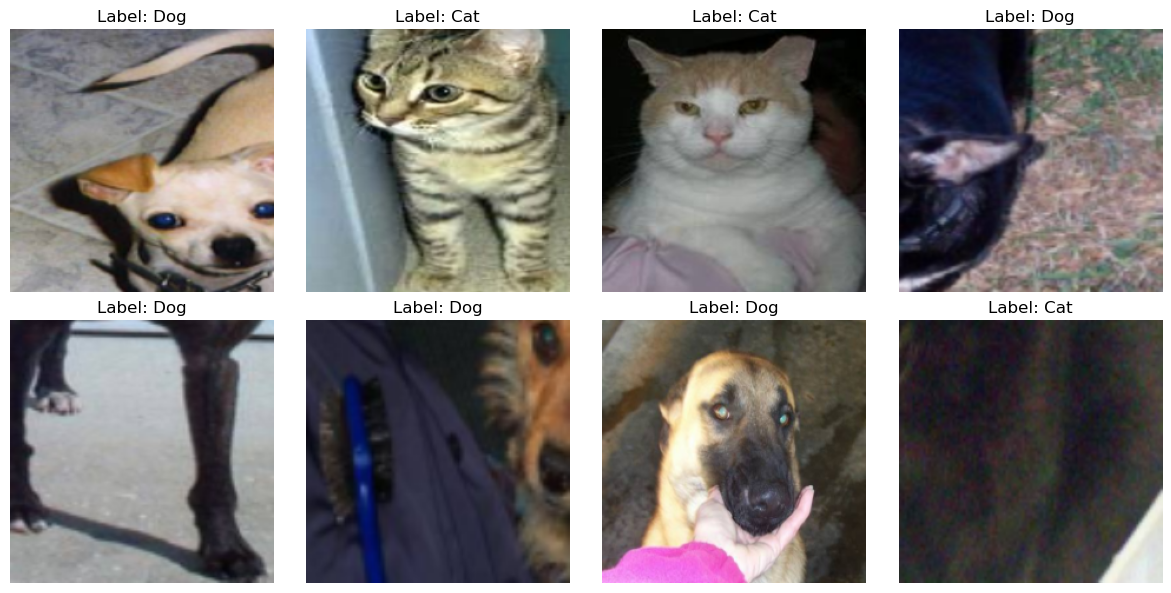

In [11]:
# Visualize some training samples
def show_images(loader, num_images=8):
    """Display a grid of sample images."""
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        label_name = "Dog" if labels[i] == 1 else "Cat"
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label_name}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images from training set:")
show_images(train_loader)

## 4. CNN Model - Feature Extraction

The CNN is used to extract meaningful features from images that will be fed to the quantum kernel.

In [12]:
# Initialize CNN model
model = CnnFeatureExtractor().to(device)
cnn_model_path = os.path.join("..", "models", "classical", "cnn_model.pth")

print("CNN Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

CNN Architecture:
CnnFeatureExtractor(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=10, bias=True)
  (fc3): Li

### Train or Load CNN Model

In [13]:
# Load or train CNN
if not RETRAIN_CNN and os.path.exists(cnn_model_path):
    print(f"Loading pre-trained CNN from {cnn_model_path}...")
    model.load_state_dict(torch.load(cnn_model_path))
    model.eval()
    print("✓ CNN model loaded successfully!")
else:
    print("Training CNN from scratch...")
    print("=" * 50)
    model = train_cnn(model, train_loader, val_loader, device, LEARNING_RATE, CNN_EPOCHS)
    
    # Save the trained model
    print(f"\nSaving CNN model to {cnn_model_path}...")
    os.makedirs(os.path.dirname(cnn_model_path), exist_ok=True)
    torch.save(model.state_dict(), cnn_model_path)
    print("✓ CNN model saved successfully!")

Loading pre-trained CNN from ..\models\classical\cnn_model.pth...
✓ CNN model loaded successfully!


C:\Users\Javi\AppData\Local\Temp\ipykernel_37252\1183565809.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cnn_model_path))


### Evaluate CNN Performance (Classical Baseline)

In [16]:
# Evaluate CNN on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        outputs, _ = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = 100 * correct / total
print(f"\nCNN Validation Accuracy (Classical Baseline): {cnn_accuracy:.2f}%")


CNN Validation Accuracy (Classical Baseline): 72.52%


## 5. Feature Extraction

Extract 10-dimensional features from images using the trained CNN. These features will be input to the quantum kernel.

In [17]:
print("Extracting features using CNN...")
train_features = []
train_labels = []
val_features = []
val_labels = []

model.eval()
with torch.no_grad():
    # Extract training features
    for data, label in tqdm(train_loader, desc="Training set"):
        _, features = model(data.to(device))
        train_features.extend(features.cpu().numpy())
        train_labels.extend(label.numpy())
    
    # Extract validation features
    for data, label in tqdm(val_loader, desc="Validation set"):
        _, features = model(data.to(device))
        val_features.extend(features.cpu().numpy())
        val_labels.extend(label.numpy())

train_features = np.array(train_features)
train_labels = np.array(train_labels)
val_features = np.array(val_features)
val_labels = np.array(val_labels)

print(f"\n✓ Feature extraction complete!")
print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")

Extracting features using CNN...


Training set:   0%|          | 0/175 [00:00<?, ?it/s]

Validation set:   0%|          | 0/75 [00:00<?, ?it/s]


✓ Feature extraction complete!
Training features shape: (17500, 10)
Validation features shape: (7500, 10)


## 6. Quantum Kernel Training

The quantum kernel uses quantum circuits to compute similarity between feature vectors. The kernel is optimized using Kernel Target Alignment (KTA).

In [19]:
# Initialize quantum kernel
quantum_model_path = os.path.join("..", "models", "quantum", "quantum_kernel.pth")

# Create kernel function
kernel, random_params = create_quantum_kernel(num_wires=NUM_WIRES, num_layers=NUM_LAYERS)

print(f"Quantum kernel created with:")
print(f"  - Number of qubits: {NUM_WIRES}")
print(f"  - Number of layers: {NUM_LAYERS}")

# Sample data for quantum training (for computational efficiency)
X_train_quantum = train_features[:TRAIN_SAMPLES_FOR_QUANTUM]
Y_train_quantum = train_labels[:TRAIN_SAMPLES_FOR_QUANTUM]
X_val_quantum = val_features[:VAL_SAMPLES_FOR_QUANTUM]
Y_val_quantum = val_labels[:VAL_SAMPLES_FOR_QUANTUM]

print(f"\nUsing {len(X_train_quantum)} training samples for quantum kernel")
print(f"Using {len(X_val_quantum)} validation samples")

Quantum kernel created with:
  - Number of qubits: 5
  - Number of layers: 3

Using 400 training samples for quantum kernel
Using 1000 validation samples


### Train or Load Quantum Kernel

In [20]:
# Load or train quantum kernel
if not RETRAIN_QUANTUM and os.path.exists(quantum_model_path):
    print(f"Loading pre-trained quantum kernel from {quantum_model_path}...")
    quantum_data = torch.load(quantum_model_path)
    kernel_params = quantum_data["kernel_params"]
    svm = quantum_data["svm_state"]
    X_train_svm = quantum_data["X_train_svm"]
    print("✓ Quantum kernel loaded successfully!")
else:
    print("Training quantum kernel...")
    print("=" * 50)
    init_params = random_params(num_wires=NUM_WIRES, num_layers=NUM_LAYERS)
    
    svm, kernel_params, X_train_svm = train_quantum_kernel(
        kernel,
        X_train_quantum,
        Y_train_quantum,
        X_val_quantum,
        Y_val_quantum,
        init_params=init_params,
        num_iterations=QUANTUM_ITERATIONS,
        learning_rate=QUANTUM_LEARNING_RATE,
    )
    
    # Save the trained quantum kernel
    print(f"\nSaving quantum kernel to {quantum_model_path}...")
    os.makedirs(os.path.dirname(quantum_model_path), exist_ok=True)
    torch.save(
        {
            "kernel_params": kernel_params,
            "svm_state": svm,
            "X_train_svm": X_train_svm
        },
        quantum_model_path,
    )
    print("✓ Quantum kernel saved successfully!")

Loading pre-trained quantum kernel from ..\models\quantum\quantum_kernel.pth...
✓ Quantum kernel loaded successfully!


C:\Users\Javi\AppData\Local\Temp\ipykernel_37252\3446133929.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantum_data = torch.load(quantum_model_path)


## 7. Model Evaluation

Evaluate the hybrid quantum-classical model on the validation set.

In [21]:
# Reconstruct trained kernel function from parameters
trained_kernel = lambda x1, x2: kernel(x1, x2, kernel_params)

# Evaluate on validation set
print("Evaluating hybrid model on validation set...")
print("=" * 50)

X_test = val_features[:TEST_SAMPLES]
Y_test = val_labels[:TEST_SAMPLES]

val_predictions = predict_with_quantum_kernel(
    svm, trained_kernel, X_train_svm, X_test
)

val_accuracy = (val_predictions == Y_test).mean()
print(f"\n{'='*50}")
print(f"Validation Accuracy (Hybrid Quantum-Classical): {val_accuracy:.3f} ({val_accuracy*100:.1f}%)")
print(f"{'='*50}")

Evaluating hybrid model on validation set...
Computing kernel matrix for 100 test samples...

Validation Accuracy (Hybrid Quantum-Classical): 0.660 (66.0%)


### Detailed Performance Analysis

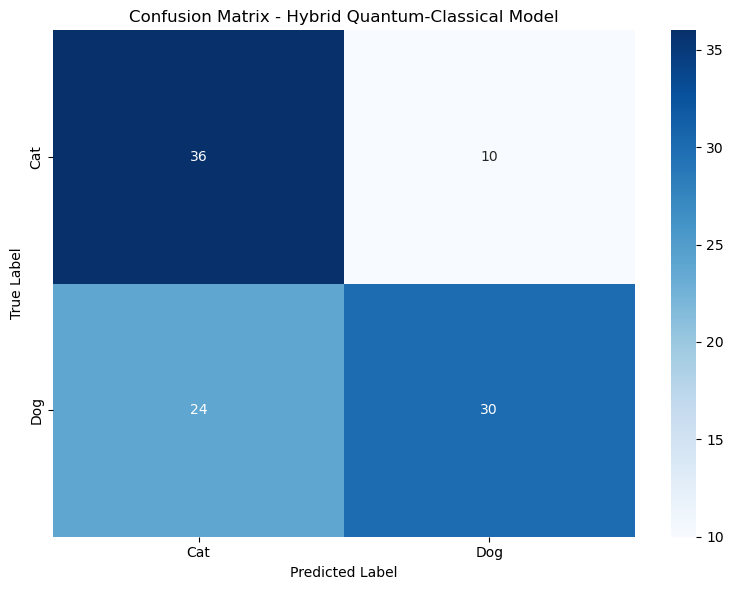


Classification Report:
              precision    recall  f1-score   support

         Cat       0.60      0.78      0.68        46
         Dog       0.75      0.56      0.64        54

    accuracy                           0.66       100
   macro avg       0.68      0.67      0.66       100
weighted avg       0.68      0.66      0.66       100



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(Y_test, val_predictions)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix - Hybrid Quantum-Classical Model')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, val_predictions, 
                          target_names=['Cat', 'Dog']))

## 8. Visualize Predictions

Sample predictions from validation set:
Computing kernel matrix for 8 test samples...


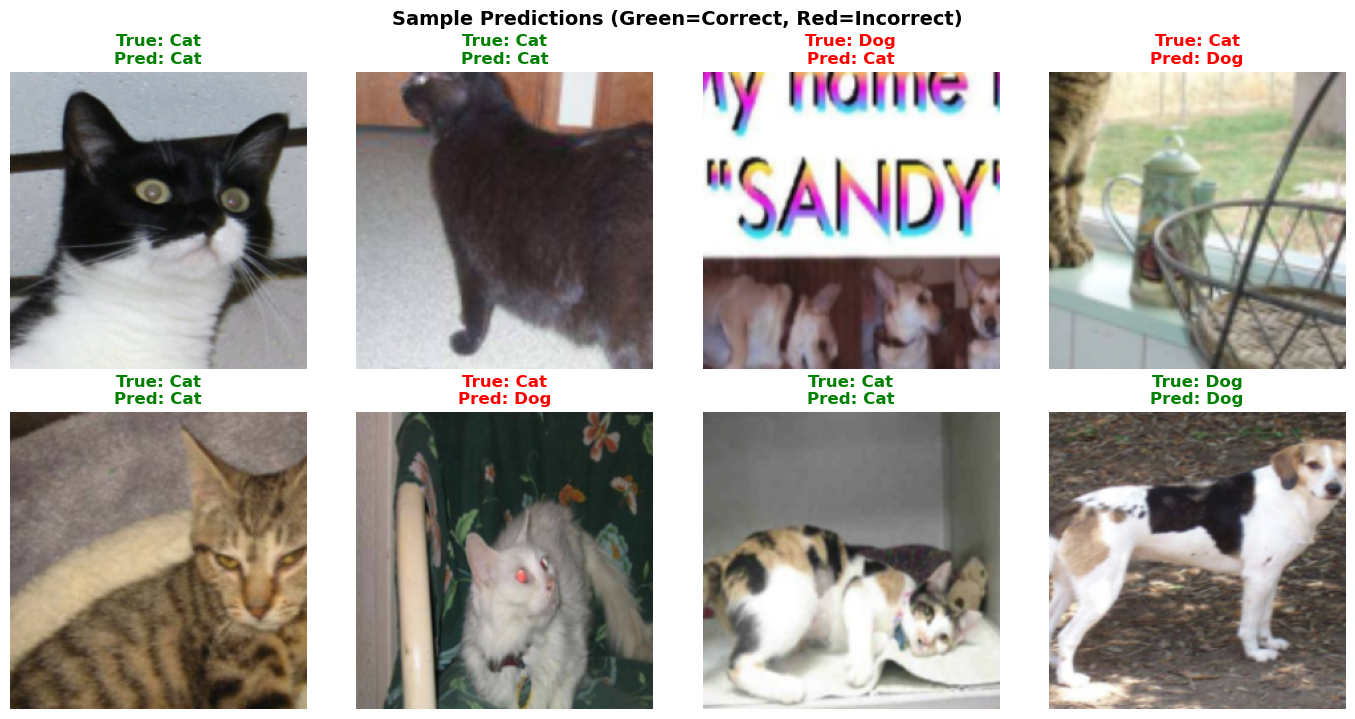

In [25]:
# Show some prediction examples
def visualize_predictions(num_samples=8):
    """Visualize model predictions on sample images."""
    # Get some validation images
    val_iter = iter(val_loader)
    images, true_labels = next(val_iter)
    
    # Extract features and predict
    model.eval()
    with torch.no_grad():
        _, features = model(images[:num_samples].to(device))
        features_np = features.cpu().numpy()
    
    predictions = predict_with_quantum_kernel(
        svm, trained_kernel, X_train_svm, features_np
    )
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    axes = axes.ravel()
    
    class_names = ['Cat', 'Dog']
    
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        true_label = class_names[true_labels[i]]
        pred_label = class_names[predictions[i]]
        
        axes[i].imshow(img)
        
        # Color code: green for correct, red for incorrect
        color = 'green' if true_labels[i] == predictions[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', 
                         color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
                y=1.02, fontsize=14, fontweight='bold')
    plt.show()

print("Sample predictions from validation set:")
visualize_predictions()

## Summary

This notebook demonstrated a hybrid quantum-classical approach for image classification:

1. **Classical CNN** extracted meaningful features from raw images
2. **Quantum Kernel** used quantum circuits to classify based on extracted features
3. **SVM** combined with the quantum kernel for final predictions

The approach leverages the strengths of both classical and quantum computing:
- Classical neural networks excel at feature extraction from complex data
- Quantum kernels can capture complex relationships in high-dimensional feature spaces

### Key Results:
- CNN Feature Extractor: 10-dimensional feature vectors
- Quantum Circuit: 5 qubits, 3 layers
- Training samples: Configurable (default: 400 for quantum kernel)
- Final accuracy: Displayed above

### Next Steps:
- Experiment with different quantum circuit architectures
- Try different numbers of qubits and layers
- Increase training samples (computational cost vs. accuracy trade-off)
- Compare with other classical baselines